# Acoustic Experiments

## Imports

In [1]:
%pylab inline
%matplotlib inline

import numpy as np
import scipy as sp
import scipy.constants as const

from scipy.io import wavfile
from sklearn import preprocessing
from scipy import signal

from scipy.signal import butter, firwin, lfilter
from scipy.signal import freqz
from scipy.signal import argrelmax

Populating the interactive namespace from numpy and matplotlib


## Constants & Global Variables

In [2]:
input_data_directory = "data"
output_data_directory = "out"

sample_rate = 44100
tone_duration = 0.05
tone_frequency0 = 2000
tone_frequency1 = 6000

def normalize_data(data):
    return data/0x7FFF

## Tone Generation

In [3]:
def generate_tone(frequency, duration, sample_rate):
    return np.sin(2 * math.pi * np.arange(math.ceil(sample_rate * duration)) * frequency / sample_rate) * 0x7FFF

def wave_period_data(data, frequency):
    return data[0:math.ceil(1/frequency*sample_rate)+1].squeeze()

def generate_chirp(frequency0, frequency1, duration, phase0=0, sample_rate=44100):
    num_samples = math.ceil(sample_rate * duration);
    k = (frequency1 - frequency0)/num_samples
    return np.sin(phase0+2*math.pi*(np.arange(num_samples)*frequency0/sample_rate+k/2*np.arange(num_samples)**2/sample_rate)) * 0x7FFF

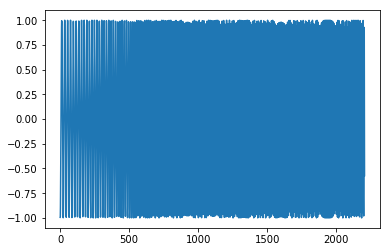

In [4]:
tone_data = generate_chirp(tone_frequency0, tone_frequency1, tone_duration, sample_rate)
wavfile.write(input_data_directory+"/audio/tone.wav", sample_rate, tone_data.astype(np.int16))
tone_data = normalize_data(tone_data)

plt.figure()
plt.plot(tone_data)

## Helper Functions

In [5]:
def load_sample(path):
    sample_rate, sample_data = wavfile.read(path)
    return sample_rate, normalize_data(sample_data)
       
def tone_correlation(sample_data, tone_frequency0, tone_frequency1, tone_data):
    correlation = sp.correlate(sample_data, tone_data, 'valid')
    return correlation

def tone_recognition(sample_data, sample_rate, duration):
    last_index = 0
    tones = []
    tone_candidates = argrelmax(sample_data, order=math.ceil(duration*sample_rate))[0]
    for candidate in tone_candidates:
        tones.append((candidate, sample_data[candidate]))
    tones.sort(key=lambda tup: tup[1])
    tones.reverse()
    
    return tones

def compute_etoa(tones, sample_rate):
    if len(tones) < 2:
        raise NameError("Insufficient Tones Detected")
    else:
        return abs(tones[0][0]-tones[1][0])/sample_rate
    
def compute_distance(etoa_a, etoa_b, d_aa, d_bb, c=340.29):
    return (c/2) * (etoa_a - etoa_b) + (d_aa + d_bb)

def device_distance(device_a_path, device_b_path, verbose=False):
    if verbose:
        print("Device A Sample:", device_a_path)
        print("Device B Sample:", device_b_path)
    
    
    device_a_sample_rate, device_a_sample_data = load_sample(device_a_path)
    if verbose:
        plt.figure()
        plt.suptitle("Device A Waveform", fontsize=16)
        plt.plot(device_a_sample_data)
    
    device_b_sample_rate, device_b_sample_data = load_sample(device_b_path)
    if verbose:
        plt.figure()
        plt.suptitle("Device B Waveform", fontsize=16)
        plt.plot(device_b_sample_data)
    
    
    device_a_correlation = tone_correlation(device_a_sample_data,
                                           tone_frequency0,
                                           tone_frequency1,
                                           tone_data)
    if verbose:
        plt.figure()
        plt.suptitle("Device A Correlation", fontsize=16)
        plt.plot(device_a_correlation)
    
    device_b_correlation = tone_correlation(device_b_sample_data,
                                           tone_frequency0,
                                           tone_frequency1,
                                           tone_data)
    if verbose:
        plt.figure()
        plt.suptitle("Device B Correlation", fontsize=16)
        plt.plot(device_b_correlation)
    
    
    device_a_tones = tone_recognition(device_a_correlation, sample_rate, tone_duration)
    if verbose:
        print("Device A")
        print("A total of",len(device_a_tones),"tones were detected.")
        print("The best candidates are (",device_a_tones[0][0],",",device_a_tones[0][1],") and (",device_a_tones[1][0],",",device_a_tones[1][1],")")  
        print("A total of",len(device_a_tones),"tones were detected.")    
    
    device_b_tones = tone_recognition(device_b_correlation, sample_rate, tone_duration)
    if verbose: 
        print("Device B")
        print("The best candidates are (",device_b_tones[0][0],",",device_b_tones[0][1],") and (",device_b_tones[1][0],",",device_b_tones[1][1],")")  
        print("A total of",len(device_b_tones),"tones were detected.")
    
    
    device_a_etoa = compute_etoa(device_a_tones, sample_rate)
    if verbose: 
        print("Device A ETOA:",device_a_etoa)
        
    device_b_etoa = compute_etoa(device_b_tones, sample_rate)
    if verbose:
        print("Device B ETOA:",device_b_etoa)

    
    distance = compute_distance(device_a_etoa, device_b_etoa, 0.04, 0.04)
    if verbose:
        print("Distance between devices in meters:", distance)
    return distance

## Trials

In [6]:
trials = [
    (input_data_directory+"/audio/trial-0-chirp-0.5m-da.wav", input_data_directory+"/audio/trial-0-chirp-0.5m-db.wav"),
    (input_data_directory+"/audio/trial-1-chirp-0.5m-da.wav", input_data_directory+"/audio/trial-1-chirp-0.5m-db.wav"),
    (input_data_directory+"/audio/trial-2-chirp-0.5m-da.wav", input_data_directory+"/audio/trial-2-chirp-0.5m-db.wav"),
    (input_data_directory+"/audio/trial-0-chirp-1m-da.wav", input_data_directory+"/audio/trial-0-chirp-1m-db.wav"),
    (input_data_directory+"/audio/trial-1-chirp-1m-da.wav", input_data_directory+"/audio/trial-1-chirp-1m-db.wav"),
    (input_data_directory+"/audio/trial-2-chirp-1m-da.wav", input_data_directory+"/audio/trial-2-chirp-1m-db.wav")
]

for trial in trials:
    print("Trial Files:\"",trial[0],"\"and\"",trial[1],"\"")
    print("Distance between devices in meters:", device_distance(trial[0], trial[1], verbose=False))
    print("----------------")



Trial Files:" data/audio/trial-0-chirp-0.5m-da.wav "and" data/audio/trial-0-chirp-0.5m-db.wav "
Distance between devices in meters: 0.558412244898
----------------
Trial Files:" data/audio/trial-1-chirp-0.5m-da.wav "and" data/audio/trial-1-chirp-0.5m-db.wav "
Distance between devices in meters: 0.488965306122
----------------
Trial Files:" data/audio/trial-2-chirp-0.5m-da.wav "and" data/audio/trial-2-chirp-0.5m-db.wav "
Distance between devices in meters: 0.431092857143
----------------
Trial Files:" data/audio/trial-0-chirp-1m-da.wav "and" data/audio/trial-0-chirp-1m-db.wav "
Distance between devices in meters: 1.10241326531
----------------
Trial Files:" data/audio/trial-1-chirp-1m-da.wav "and" data/audio/trial-1-chirp-1m-db.wav "
Distance between devices in meters: 0.924937755102
----------------
Trial Files:" data/audio/trial-2-chirp-1m-da.wav "and" data/audio/trial-2-chirp-1m-db.wav "
Distance between devices in meters: 0.998242857143
----------------
